In [1]:
#expand cell width to 100%
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#import listdir
from os import listdir
#import regex
import re
#import numpy
import numpy as np
#import struct to convert byte to float32
import struct
#import minidom from xml.dom
from xml.dom import minidom

In [3]:
#set the directory containing the .txt files with the abundances
abundanceFilesDirectory="D:/Non-academic/GSOC23/GammaRaySpectroscopy/5DegreeEstimates"

In [4]:
#get the names of the files in the directoty
fileNames=listdir(abundanceFilesDirectory)

In [5]:
#create lists to hold the extent (min max of lat and long)
minLats=[]
maxLats=[]
minLongs=[]
maxLongs=[]
#create list of lists to hold the abundances
allAbundances=[]

In [6]:
#create a flag to check wether the lat longs are to be saved
flag=True
#iterate over all the files
for currentFileName in fileNames:
    #open the files and read all the lines
    with open(abundanceFilesDirectory+'/'+currentFileName) as currentFile:
        fileLines=currentFile.readlines()
    #drop lines 0-12 as they contain description of the data
    fileLines=fileLines[13:]
    #create a list to hold the current abundances
    currentAbundances=[]
    #iterate through each line
    for currentLine in fileLines:
        #extract the extent and abundances
        minLat,maxLat,minLong,maxLong,abundance=list(map(float,re.findall("-?\d+\.\d+",currentLine)))
        if flag:
            minLats.append(minLat)
            maxLats.append(maxLat)
            minLongs.append(minLong)
            maxLongs.append(maxLong)
        currentAbundances.append(abundance)
    allAbundances.append(np.array(currentAbundances))
    if flag:
        flag=False
#convert lat and longs to numpy array
minLats=np.array(minLats)
maxLats=np.array(maxLats)
minLongs=np.array(minLongs)
maxLongs=np.array(maxLongs)

In [7]:
#define a function which takes the addresses of a .dat file and its associated .xml file
#reads the parameters from the .xml file uses it to read the spectra from the .dat file
#returns a dataframe where each row corresponds to each record in the .dat file
def readGRSData(datFileAddress,xmlFileAddress):
    #create a list containing the fields to be read from the .dat file
    requiredFields=['Spacecraft_Altitude','Subspacecraft_Latitude','Subspacecraft_Longitude']
    #read the xml file
    xmlFile=minidom.parse(xmlFileAddress)
    #get the elements describing the columns of the .dat file
    columnElements=xmlFile.getElementsByTagName('Field_Binary')
    #create an empty list to hold the indices of the columns to be read
    requiredColumnIndices=[]
    #create an empty list to hold the no. of bytes per element for each column to be read
    bytesPerItermPerColumn=[]
    #create an empty list to hold the number of the starting position for each column
    startingBytePerColumn=[]
    #iterate over the names of the fields in the current data record
    for i in range(len(columnElements)):
        #iterate over the required fields
        for j in requiredFields:
            #if the current field is required save its index, starting bytes, and length in bytes
            if columnElements[i].getElementsByTagName('name')[0].firstChild.nodeValue==j:
                requiredColumnIndices.append(i)
                startingBytePerColumn.append(int(columnElements[i].getElementsByTagName('field_location')[0].firstChild.nodeValue))
                bytesPerItermPerColumn.append(int(columnElements[i].getElementsByTagName('field_length')[0].firstChild.nodeValue))

    #create two dictionaries marking the starting byte and length for the accepted and rejected spectra
    acceptedSpectraDescription={"startingByte":-1,"noOfBytes":-1}
    rejectedSpectraDescription={"startingByte":-1,"noOfBytes":-1}
    #get element describing the accepted spectra in the .dat file

    acceptedSpectraElement=xmlFile.getElementsByTagName('Group_Field_Binary')[0]
    #save the starting position
    acceptedSpectraDescription["startingByte"]=int(acceptedSpectraElement.getElementsByTagName('group_location')[0].firstChild.nodeValue)
    #save the ending position
    acceptedSpectraDescription["noOfBytes"]=int(acceptedSpectraElement.getElementsByTagName('group_length')[0].firstChild.nodeValue)

    #get element describing the accepted spectra in the .dat file
    rejectedSpectraElement=xmlFile.getElementsByTagName('Group_Field_Binary')[1]
    #save the starting position
    rejectedSpectraDescription["startingByte"]=int(rejectedSpectraElement.getElementsByTagName('group_location')[0].firstChild.nodeValue)
    #save the ending position
    rejectedSpectraDescription["noOfBytes"]=int(rejectedSpectraElement.getElementsByTagName('group_length')[0].firstChild.nodeValue)
    #save the number of records in the .dat file
    noOfRecords=int(xmlFile.getElementsByTagName('Table_Binary')[0].getElementsByTagName('records')[0].firstChild.nodeValue)
    #save the number of bytes per record
    noOfBytesPerRecord=int(xmlFile.getElementsByTagName('Table_Binary')[0].getElementsByTagName('Record_Binary')[0].getElementsByTagName('record_length')[0].firstChild.nodeValue)


    #create an empty list to hold each byte of each record in the .data file
    datFileBytes=[]
    #open the .dat file
    with open(datFileAddress,mode='rb') as datFile:
        #iterate over each record
        for i in range(noOfRecords):
            #create a temporary list hold the bytes of each record
            currentRecordBytes=[]
            #iterate over all bytes in the record
            for j in range(noOfBytesPerRecord):
                #read each byte of the .dat file seperately into an array
                currentRecordBytes.append(datFile.read(1))
            #add the current record to the list of bytes
            datFileBytes.append(currentRecordBytes)

    #set the number of bytes per channel
    bytesPerChannel=4
    #set the number of channels in the spectra
    channelsPerSpectra=int(acceptedSpectraDescription["noOfBytes"]/bytesPerChannel)

    #create empty arrays to hold:
    #accepted spectra
    acceptedSpectras=[]
    #rejected spectra
    rejectedSpectras=[]
    #altitudes
    altitudes=[]
    #latitudes
    latitudes=[]
    #longitudes
    longitudes=[]

    #iterate through all the records
    for i in range(len(datFileBytes)):
        #get the bytes for the current record
        currentRecordBytes=datFileBytes[i]
        #read the bytes for the accepted spectra
        acceptedSpectraBytes=currentRecordBytes[acceptedSpectraDescription["startingByte"]-1:acceptedSpectraDescription["startingByte"]-1+acceptedSpectraDescription["noOfBytes"]]
        #read the accepted spectra for the current record
        acceptedSpectra=[]
        #iterate through each channel in the spectra
        for j in range(channelsPerSpectra):
            #get the staring index of the channel
            startIndex=bytesPerChannel*j
            #get the end+1 index of the channel
            endIndex=startIndex+4
            #get the bytes making up the current channel
            currentChannelBytes=acceptedSpectraBytes[startIndex:endIndex]
            #combine list into a single variable
            currentChannelBytes=currentChannelBytes[0]+currentChannelBytes[1]+currentChannelBytes[2]+currentChannelBytes[3]
            #convert the byte data into float 32 and append it to the spectra
            acceptedSpectra.append(struct.unpack('f',currentChannelBytes)[0])

        #read the bytes for the rejected spectra
        rejectedSpectraBytes=currentRecordBytes[rejectedSpectraDescription["startingByte"]-1:rejectedSpectraDescription["startingByte"]-1+rejectedSpectraDescription["noOfBytes"]]
        #read the rejected spectra for the current record
        rejectedSpectra=[]
        #iterate through each channel in the spectra
        for j in range(channelsPerSpectra):
            #get the staring index of the channel
            startIndex=bytesPerChannel*j
            #get the end+1 index of the channel
            endIndex=startIndex+4
            #get the bytes making up the current channel
            currentChannelBytes=rejectedSpectraBytes[startIndex:endIndex]
            #combine list into a single variable
            currentChannelBytes=currentChannelBytes[0]+currentChannelBytes[1]+currentChannelBytes[2]+currentChannelBytes[3]
            #convert the byte data into float 32 and append it to the spectra
            rejectedSpectra.append(struct.unpack('f',currentChannelBytes)[0])

        #read the alltitude
        altitudeBytes=currentRecordBytes[startingBytePerColumn[0]-1:startingBytePerColumn[0]-1+bytesPerItermPerColumn[0]]
        altitudeBytes=altitudeBytes[0]+altitudeBytes[1]+altitudeBytes[2]+altitudeBytes[3]
        altitude=struct.unpack('f',altitudeBytes)[0]
        #read the latitude
        latitudeBytes=currentRecordBytes[startingBytePerColumn[1]-1:startingBytePerColumn[1]-1+bytesPerItermPerColumn[1]]
        latitudeBytes=latitudeBytes[0]+latitudeBytes[1]+latitudeBytes[2]+latitudeBytes[3]
        latitude=struct.unpack('f',latitudeBytes)[0]
        #read the longitude
        longitudeBytes=currentRecordBytes[startingBytePerColumn[2]-1:startingBytePerColumn[2]-1+bytesPerItermPerColumn[2]]
        longitudeBytes=longitudeBytes[0]+longitudeBytes[1]+longitudeBytes[2]+longitudeBytes[3]
        longitude=struct.unpack('f',longitudeBytes)[0]

        #append all five to their respective lists
        #accepted spectra
        acceptedSpectras.append(np.array(acceptedSpectra))
        #rejected spectra
        rejectedSpectras.append(np.array(rejectedSpectra))
        #altitudes
        altitudes.append(altitude)
        #latitudes
        latitudes.append(latitude)
        #longitudes
        longitudes.append(longitude)
        
    return np.array(acceptedSpectras),np.array(altitudes),np.array(latitudes),np.array(longitudes)
    
    

In [8]:
#get the directory where the files with the spectra are saved
spectraDirectory="D:/Non-academic/GSOC23/GammaRaySpectroscopy/Dataset"
#get names of the .xml and .dat files
allFiles=listdir(spectraDirectory)
#create lists to hold the .xml and .dat file addresses
xmlFileAddresses=[]
datFileAddresses=[]
#iterate through all the files and seperate them into .xml and .dat files
for currentFileName in allFiles:
    if currentFileName[-3:]=='dat':
        datFileAddresses.append(currentFileName)
    elif currentFileName[-3:]=='xml':
        xmlFileAddresses.append(currentFileName)

In [9]:
#create a list of numpy of arrays where each element in the list corresponds to the summed spectra of the corresponding 5 degree region
summedSpectra=[np.zeros(512)]*maxLongs.shape[0]
#create a list to hold the number of spectra in each region
noOfSpectraPerRegion=[0]*maxLongs.shape[0]

In [10]:
#specify the altitude
desiredAltitude=100
tolerance=10
#iterate through all the .dat, .xml file combinations to read all the spectra
for xmlFileAddress,datFileAddress in zip(xmlFileAddresses,datFileAddresses):
    #read the data from the dataframe
    acceptedSpectras,altitudes,latitudes,longitudes=readGRSData(spectraDirectory+'/'+datFileAddress,spectraDirectory+'/'+xmlFileAddress)
    
    #change longitude values between 180 and 360 to -180 to 0
    longitudes=np.where(longitudes>=180,longitudes-360,longitudes)
    #iterate over each region
    for i,minLat,maxLat,minLong,maxLong in zip(range(minLats.shape[0]),minLats,maxLats,minLongs,maxLongs):
        #get the indices of the spectra that are in the current region
        currentRegionSpectraIndices=np.where(np.logical_and(np.logical_and(np.logical_and(longitudes<=maxLat,
                                                                                          longitudes>=minLat),
                                                                           np.logical_and(latitudes<=maxLat,
                                                                                          latitudes>=minLat)),
                                                            np.logical_and(altitudes>=desiredAltitude-tolerance,
                                                                           altitudes<=desiredAltitude+tolerance)))[0]
        #get the spectra in the region
        if len(currentRegionSpectraIndices)>0:
            summedSpectra[i]=summedSpectra[i]+np.sum(acceptedSpectras[currentRegionSpectraIndices,:],axis=0)
            noOfSpectraPerRegion[i]+=len(currentRegionSpectraIndices)

In [16]:
#compute average spectra per region
averagedSpectra=[np.zeros(512)]*maxLongs.shape[0]
#iterate over all regions
for i in range(len(summedSpectra)):
    averagedSpectra[i]=summedSpectra[i]/noOfSpectraPerRegion[i]

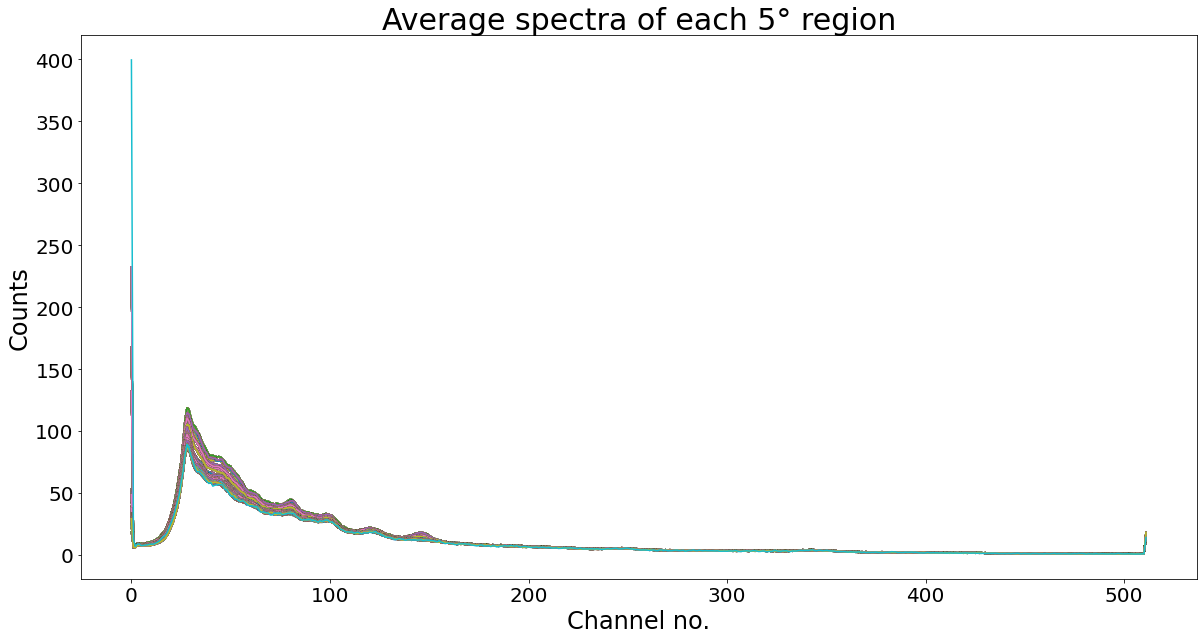

In [18]:
#plot all the spectra
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Channel no.",fontsize=24)
plt.ylabel("Counts",fontsize=24)
plt.title("Average spectra of each 5\u00B0 region",fontsize=30)
for i in averagedSpectra:
    plt.plot(np.arange(i.shape[0]),i)

In [15]:
minLats=minLats.tolist()
maxLats=maxLats.tolist()
minLongs=minLongs.tolist()
maxLongs=maxLongs.tolist()

1790

In [24]:
#create a dictionary from the the lists
dataDictionary={'minLats':minLats,
                'maxLats':maxLats,
                'minLongs':minLongs,
                'maxLongs':maxLongs,
                'averageSpectra':averagedSpectra,}

In [30]:
#add abundances to the dictionary
for i in range(len(fileNames)):
    currentFileName=fileNames[i][:fileNames[i].index('5d.txt')]
    currentAbundance=allAbundances[i].tolist()
    dataDictionary.update({currentFileName:currentAbundance})

In [33]:
#save dataset as dataframe
import pandas as pd
dataFrame=pd.DataFrame.from_dict(dataDictionary)
dataFrameAddress="D:/Non-academic/GSOC23/GammaRaySpectroscopy/Dataset/5DegreeDataset.csv"
dataFrame.to_csv(dataFrameAddress)